In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import asyncio
import os
import pandas as pd
import numpy as np

from hfppl.modeling import Model
from hfppl.distributions import LMContext, TokenCategorical
from hfppl.llms import CachedCausalLM
from hfppl.inference import smc_standard

from battleship.board import Board
from battleship.scoring import compute_score

In [4]:
# Load HF_AUTH_TOKEN from .hf_auth_token
with open(os.path.join("../", ".hf_auth_token"), "r") as f:
    os.environ["HF_AUTH_TOKEN"] = f.read().strip()

HF_AUTH_TOKEN = os.environ["HF_AUTH_TOKEN"]

In [5]:
# Initialize the HuggingFace model
lm = CachedCausalLM.from_pretrained("codellama/CodeLlama-7b-hf", auth_token=HF_AUTH_TOKEN)

/home/ubuntu/battleship/.venv/lib/python3.11/site-packages/transformers/models/auto/tokenization_auto.py:671: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/home/ubuntu/battleship/.venv/lib/python3.11/site-packages/transformers/models/auto/auto_factory.py:472: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/ubuntu/battleship/.venv/lib/python3.11/site-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


# Battleship model

In [6]:
df = pd.read_csv("../battleship/prompts/examples.csv")

def format_example(user_input: str, response: str = None):
    return f"User: {user_input}\n" f"Assistant:{' ' + response if response else ''}"

def make_question_prompt(df):
    prompt = "\n".join(df.question) + "\n"
    return prompt

def make_question_to_code_prompt(df):
    prompt = "\n".join([format_example(q, r) for q, r in zip(df.question, df.code)]) + "\n"
    return prompt

In [7]:
print(make_question_prompt(df))

How many blocks is the red ship?
Does the purple ship have 4 tiles?
Is the purple ship horizontal or vertical?
Does the purple ship go upwards?
What is at B1?
Is there a ship at F3?
Is the purple ship touching the blue ship?
What are the coordinate of the first block of the red ship?
What is the rightmost square occupied by the purple ship?
Are any of the ships horizontal?
How many ships are vertical?
How many total squares are occupied by ships?



In [8]:
print(make_question_to_code_prompt(df))

User: How many blocks is the red ship?
Assistant: (size Red)
User: Does the purple ship have 4 tiles?
Assistant: (== (size Purple) 4)
User: Is the purple ship horizontal or vertical?
Assistant: (orient Purple)
User: Does the purple ship go upwards?
Assistant: (== (orient Purple) V)
User: What is at B1?
Assistant: (color B-1)
User: Is there a ship at F3?
Assistant: (not (== (color F-3) Water))
User: Is the purple ship touching the blue ship?
Assistant: (touch Purple Blue)
User: What are the coordinate of the first block of the red ship?
Assistant: (topleft (coloredTiles Red))
User: What is the rightmost square occupied by the purple ship?
Assistant: (bottomright (coloredTiles Purple))
User: Are any of the ships horizontal?
Assistant: (any (map (lambda x0 (== (orient x0) H)) (set AllColors)))
User: How many ships are vertical?
Assistant: (++ (map (lambda x0 (== (orient x0) V)) (set AllColors)))
User: How many total squares are occupied by ships?
Assistant: (++ (map (lambda x0 (size x0)) 

In [15]:
class QuestionGenerationModel(Model):
    def __init__(self, lm: CachedCausalLM, board: Board, question_prompt: str, translation_prompt: str, n_rollouts: int = 3, max_tokens: int = 32):
        super().__init__()
        self.lm = lm
        self.context = LMContext(lm, question_prompt)
        self.program = None

        self.board = board

        self.question_prompt = question_prompt
        self.translation_prompt = translation_prompt

        self.n_rollouts = n_rollouts
        self.max_tokens = max_tokens

    async def step(self):

        token = await self.sample(self.context.next_token())

        results = await asyncio.gather(*[self.rollout(str(self.context)) for _ in range(self.n_rollouts)])
        score_mean = np.mean([result["score"] for result in results])
        # self.twist(score_mean)
        self.score(score_mean)

        print(f"Partial question: {str(self.context)}")
        print(f"|- EIG mean: {score_mean:.4f}")
        print(f"|- Particle weight: {self.weight:.4f}")
        for result in results:
            print(f"  |- Completion: {result['completion']}")
            print(f"    |- Translation: {result['translation']}")
            print(f"    |- Score: {result['score']:.4f}")
        print()

        if self.is_final_token(token) or self.is_final_context(self.context):
            translation = await self._translate_question(str(self.context))
            self.program = translation
            score = compute_score(board=self.board, program=translation)
            self.condition(score > 0)
            self.finish()

    async def rollout(self, question: str):
        completion = await self._complete_question(question)
        translation = await self._translate_question(completion)
        score = compute_score(board=self.board, program=translation)
        return {"completion": completion, "translation": translation, "score": score}

    async def _complete_question(self, question: str, temp: float = 0.7):
        # Complete the question
        ctx = LMContext(self.lm, self.question_prompt + question, temp=temp)
        for _ in range(self.max_tokens):
            token = await self.sample(ctx.next_token())
            if self.is_final_token(token):
                break
            if self.is_final_context(ctx):
                break
        completion = question + str(ctx).split("\n")[0]
        completion = completion.strip()
        return completion

    async def _translate_question(self, completion: str, temp: float = 0.1):
        # Translate the question to code
        ctx = LMContext(self.lm, self.translation_prompt + format_example(completion), temp=temp)
        for _ in range(self.max_tokens):
            token = await self.sample(ctx.next_token())
            if self.is_final_token(token, include_punctuation=False):
                break
            if self.is_final_context(ctx):
                break
        translation = str(ctx).split("\n")[0]
        translation = translation.strip()
        return translation

    def is_final_token(self, token, include_punctuation: bool = True, include_newline: bool = True):
        if token.token_id == self.lm.tokenizer.eos_token_id:
            return True
        if include_punctuation and str(token) in ['.', '!', '?']:
            return True
        if include_newline and str(token) in ['\n']:
            return True
        return False

    def is_final_context(self, context):
        if "\n" in str(context):
            return True

    def immutable_properties(self):
        return set([])

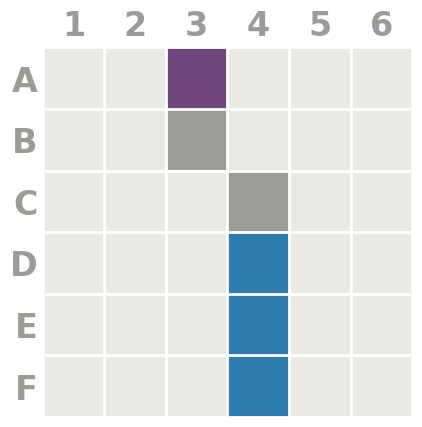

In [16]:
board = Board.from_trial_id(5)
board

In [17]:
# Create a model instance
model = QuestionGenerationModel(
    lm=lm,
    board=board,
    question_prompt=make_question_prompt(df),
    translation_prompt=make_question_to_code_prompt(df),
)

In [25]:
particles = await smc_standard(model, n_particles=1)


Partial question: If
|- Score mean: 0.9986
|- Particle weight: 0.9986
  |- Completion: If I move the nose of the purple ship one square east, how many squares would I have to move the nose of the blue ship to move the ships the
    |- Translation: (++ (map (lambda x0 (size x0)) (set AllColors)))
    |- Score: 2.1142
  |- Completion: If the blue ship has 4 tiles, where is B4?
    |- Translation: (if (== (size Blue) 4) (color B-4) (color B-5))
    |- Score: 0.0000
  |- Completion: If the ships were spotted in random order, how many ships would be horizontal?
    |- Translation: (++ (map (lambda x0 (== (orient x0) H)) (set AllColors)))
    |- Score: 0.8815

Partial question: If the
|- Score mean: 0.0000
|- Particle weight: 0.9986
  |- Completion: If the red ship were to move one block to the right, what square would it be touching?
    |- Translation: (touch (coloredTiles Red) (move (coloredTiles Red) R))
    |- Score: 0.0000
  |- Completion: If the ship starts at A1 and goes 10 squares h

In [27]:
for p in particles:
    print(f"Question: {str(p.context)}")
    print(f"|- Program: {p.program}")
    print(f"|- EIG: {compute_score(board=board, program=p.program)}")
    print(f"|- Particle weight: {p.weight:.4f}")
    print()

Question: If the rightmost square for the red ship was F5, what is the coordinate of the rightmost square for the purple ship?
|- Program: (bottomright (coloredTiles Purple))
|- EIG: 1.898524
|- Particle weight: 47.9195

